In [91]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets
import jax.numpy as jnp
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
import seaborn as sns


## Preprocess

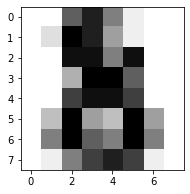

In [92]:
# Load the digits dataset
digits = datasets.load_digits()

# Display the last digit
plt.figure(1, figsize=(3, 3))
plt.imshow(digits.images[-1], cmap=plt.cm.gray_r, interpolation="nearest")
plt.show()

Number of digits in the dataset: 1797
Class distribution: {0: 178, 1: 182, 2: 177, 3: 183, 4: 181, 5: 182, 6: 181, 7: 179, 8: 174, 9: 180}


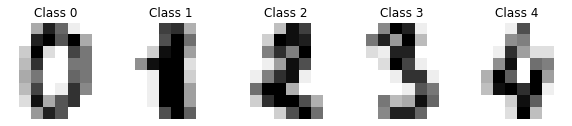

In [93]:
# 1. Count the number of digits
num_digits = len(digits.images)
print(f"Number of digits in the dataset: {num_digits}")

# Count the distribution of each class
unique, counts = np.unique(digits.target, return_counts=True)
class_distribution = dict(zip(unique, counts))
print("Class distribution:", class_distribution)

# 2. View some digits from the classes 0, 1, 2, 3, 4
fig, axs = plt.subplots(1, 5, figsize=(10, 3))
classes_to_view = [0, 1, 2, 3, 4]
for i, cls in enumerate(classes_to_view):
    # Get the first image of each class
    idx = np.where(digits.target == cls)[0][0]
    axs[i].imshow(digits.images[idx], cmap=plt.cm.gray_r, interpolation='nearest')
    axs[i].set_title(f'Class {cls}')
    axs[i].axis('off')

plt.show()


## Filtering only few classes

In [94]:
classes_to_keep = [0, 1, 2, 3, 4]
indices_to_keep = np.isin(digits.target, classes_to_keep)

filtered_images = digits.images[indices_to_keep]
filtered_labels = digits.target[indices_to_keep]

# Print the number of images and class distribution in the filtered dataset
num_filtered_images = len(filtered_images)
print(f"Number of filtered images: {num_filtered_images}")

unique_filtered, counts_filtered = np.unique(filtered_labels, return_counts=True)
filtered_class_distribution = dict(zip(unique_filtered, counts_filtered))
print("Filtered class distribution:", filtered_class_distribution)

Number of filtered images: 901
Filtered class distribution: {0: 178, 1: 182, 2: 177, 3: 183, 4: 181}


## Utilities for rotations

In [95]:
def inverse_grid_number(n, number):
    if 1 <= number <= n**2:
        row_index = (number - 1) // n + 1
        column_index = (number - 1) % n + 1
        return row_index, column_index
    else:
        raise ValueError("Number must be between 1 and n^2 inclusive.")

def grid_number(n, a, b):
    if 1 <= a <= n and 1 <= b <= n:
        return (a - 1) * n + b
    else:
        raise ValueError("Row and column indices must be between 1 and n inclusive.")

def reflection_grid(n, coordinates):
    a, b = coordinates
    reflected_b = n - b + 1
    return a, reflected_b

def rotation_grid(n, coordinates):
    a, b = coordinates
    rotated_a = n - b + 1
    rotated_b = a
    return rotated_a, rotated_b

def rotate(n, number):
    (a,b) = inverse_grid_number(n, number)
    (new_a, new_b) = rotation_grid(n, (a,b))
    return grid_number(n, new_a, new_b)

def reflect(n, number):
    (a,b) = inverse_grid_number(n, number)
    (new_a, new_b) = reflection_grid(n, (a,b))
    return grid_number(n, new_a, new_b)

def generate_rotation_matrix(n):
    # Define the size of the matrix
    matrix_size = n ** 2

    # Initialize a matrix with zeros
    rotation_matrix = jnp.zeros((matrix_size, matrix_size), dtype=int)

    # Set 1 at the specified positions for each column
    for m in range(1, matrix_size + 1):
        rotated_position = rotate(n, m)
        rotation_matrix = rotation_matrix.at[rotated_position - 1, m - 1].set(1)  # Adjust for 0-based indexing

    return rotation_matrix

def generate_reflection_matrix(n):
    # Define the size of the matrix
    matrix_size = n ** 2

    # Initialize a matrix with zeros
    reflection_matrix = jnp.zeros((matrix_size, matrix_size), dtype=int)

    # Set 1 at the specified positions for each column
    for m in range(1, matrix_size + 1):
        reflected_position = reflect(n, m)
        reflection_matrix = reflection_matrix.at[reflected_position - 1, m - 1].set(1)  # Adjust for 0-based indexing

    return reflection_matrix

def generate_d4_matrices(n):
    '''Outputs n^2 by n^2 matrices'''
    # Get rotation and reflection matrices
    R = generate_rotation_matrix(n)
    S = generate_reflection_matrix(n)

    # Calculate R^2, R^3, SR, SR^2, SR^3
    R2 = jnp.dot(R, R)
    R3 = jnp.dot(R2, R)
    SR = jnp.dot(S, R)
    SR2 = jnp.dot(S, R2)
    SR3 = jnp.dot(S, R3)

    # Generate D4 matrices
    D4_matrices = [jnp.eye(n**2), R, R2, R3, S, SR, SR2, SR3]

    return D4_matrices



In [100]:
def apply_transformation(image, transformation_matrix):
    flat_image = image.flatten()
    transformed_flat_image = jnp.dot(transformation_matrix, flat_image)
    return transformed_flat_image.reshape((n, n))

def apply_transformation_tf(image, matrix, n):
    flat_image = tf.reshape(image, [n**2])
    transformed_flat_image = tf.linalg.matvec(matrix, flat_image)
    transformed_image = tf.reshape(transformed_flat_image, [n, n])
    return transformed_image

## Augmenting the dataset

901
augmented images shape: (7208, 8, 8)
Number of augmented images: 7208
Augmented class distribution: {0: 1424, 1: 1456, 2: 1416, 3: 1464, 4: 1448}


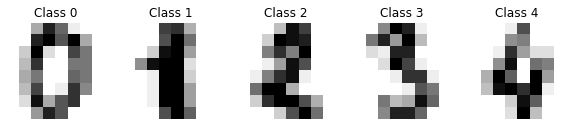

In [96]:
# Generate D4 rotation matrices for 8x8 images
n = 8
d4_matrices = generate_d4_matrices(n)

# Function to apply a transformation matrix to an image
def apply_transformation(image, transformation_matrix):
    flat_image = image.flatten()
    transformed_flat_image = jnp.dot(transformation_matrix, flat_image)
    return transformed_flat_image.reshape((n, n))

def apply_transformation_tf(image, matrix, n):
    flat_image = tf.reshape(image, [n**2])
    transformed_flat_image = tf.linalg.matvec(matrix, flat_image)
    transformed_image = tf.reshape(transformed_flat_image, [n, n])
    return transformed_image


# Create augmented dataset
augmented_images = []
augmented_labels = []

print(len(filtered_images))

for img, lbl in zip(filtered_images, filtered_labels):
    for matrix in d4_matrices:
        transformed_image = apply_transformation(img, matrix)
        augmented_images.append(transformed_image)
        augmented_labels.append(lbl)


augmented_images = np.array(augmented_images)
augmented_labels = np.array(augmented_labels)

print(f"augmented images shape: {augmented_images.shape}")

# Print the number of images and class distribution in the augmented dataset
num_augmented_images = len(augmented_images)
print(f"Number of augmented images: {num_augmented_images}")

unique_augmented, counts_augmented = np.unique(augmented_labels, return_counts=True)
augmented_class_distribution = dict(zip(unique_augmented, counts_augmented))
print("Augmented class distribution:", augmented_class_distribution)

# Display some of the augmented digits
fig, axs = plt.subplots(1, 5, figsize=(10, 3))
for i, cls in enumerate(classes_to_keep):
    # Get the first image of each class in the augmented dataset
    idx = np.where(augmented_labels == cls)[0][0]
    axs[i].imshow(augmented_images[idx], cmap=plt.cm.gray_r, interpolation='nearest')
    axs[i].set_title(f'Class {cls}')
    axs[i].axis('off')

plt.show()

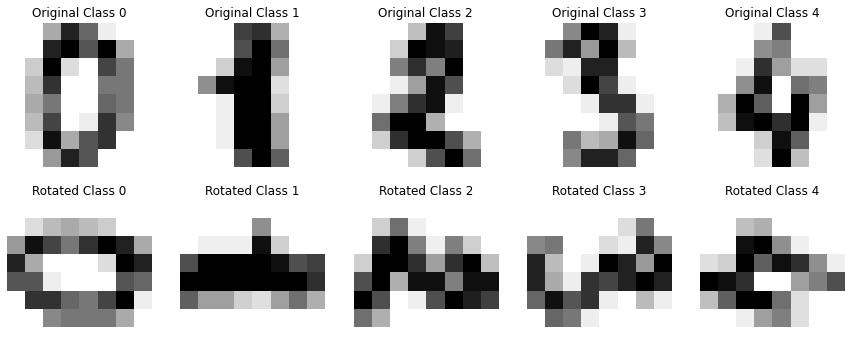

In [97]:
fig, axs = plt.subplots(2, 5, figsize=(15, 6))
for i, cls in enumerate(classes_to_keep):
    # Get the first image of each class in the original dataset
    idx_original = np.where(filtered_labels == cls)[0][0]
    axs[0, i].imshow(filtered_images[idx_original], cmap=plt.cm.gray_r, interpolation='nearest')
    axs[0, i].set_title(f'Original Class {cls}')
    axs[0, i].axis('off')
    
    # Get the first rotated image of the same class in the augmented dataset
    idx_augmented = np.where(augmented_labels == cls)[0][3]
    axs[1, i].imshow(augmented_images[idx_augmented], cmap=plt.cm.gray_r, interpolation='nearest')
    axs[1, i].set_title(f'Rotated Class {cls}')
    axs[1, i].axis('off')

plt.show()

In [98]:
augmented_images = augmented_images / 16.0

In [99]:
num_classes = 4
augmented_labels = tf.keras.utils.to_categorical(augmented_labels, num_classes)

IndexError: index 4 is out of bounds for axis 1 with size 4

In [71]:
X_train, X_test, y_train, y_test = train_test_split(augmented_images, augmented_labels, test_size=0.2, random_state=42)
reps = tf.transpose(tf.stack(generate_d4_matrices(8), axis=0), perm = (0, 2, 1))
# ids = tf.transpose(tf.stack([np.eye(8) for i in range(8)], axis=0), perm = (0, 2, 1))

In [73]:
y_train.shape

(4633,)

### The below cell is ONLY if we want to preprocess first

In [ ]:

X_train = tf.reduce_sum(tf.transpose(tf.reshape((tf.reshape(X_train, (-1, 1, 1, 64)) @ reps), (-1, 8, 8, 8)), perm=[0,2,3,1]), -1)
X_test = tf.reduce_sum(tf.transpose(tf.reshape((tf.reshape(X_test, (-1, 1, 1, 64)) @ reps), (-1, 8, 8, 8)), perm=[0,2,3,1]), -1)

# Basic conv model

In [16]:
class FirstConvModel(tf.keras.Model):
    def __init__(self, num_filters, kernel_size, padding, activation):
        super().__init__()
        self.flatten = layers.Flatten()
        self.dense = layers.Dense(64, activation='relu')
        self.softmax = layers.Dense(num_classes, activation='softmax')
        self.conv = layers.Conv2D(num_filters, kernel_size=kernel_size, padding=padding, activation=activation, data_format="channels_last")


    def call(self, inputs):
        temp = self.conv(inputs)
        print(f"shape after convolution is{temp.shape}")
        temp = self.flatten(temp)
        print(f"shape after flattening is: {temp.shape}")
        temp = self.dense(temp)
        temp = self.softmax(temp)
        return temp
        # print(inputs.shape)
        # temp = tf.reshape((tf.squeeze(tf.expand_dims(inputs.reshape((-1, 1, 64)), axis=-2) @ self.reps)),(-1, 8, 8, 8))
        # print(temp.shape)
        # print((tf.expand_dims(temp[:,i,:,:], axis=-1).shape))
        # temp = sum([self.conv(tf.expand_dims(temp[:,i,:,:]), axis=-1) for i in range(8)])
        # temp = self.flatten(temp)
        # temp = self.dense(temp)
        # temp = self.softmax(temp)
        # return temp

In [ ]:
# Build the CNN model


model = models.Sequential([
    ConvLayer(1, (8, 8), activation='relu', padding='same'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

model = ConvModel(1, (8, 8), activation='relu', padding='same')

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
# Train the model
X_train_tf = tf.convert_to_tensor(X_train, dtype=tf.float32)
print(f"X shape is: {X_train_tf.shape}, Y shape is: {y_train.shape}")
history = model.fit(X_train_tf, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f"Test accuracy: {test_acc}")

# Conv model attempt round 2

In [15]:
class AverageD4layer(tf.keras.layers.Layer):
    def __init__(self, n, **kwargs):
        super(AverageD4layer, self).__init__(**kwargs)
        self.n = n
        self.d4_matrices = convert_d4_matrices_to_tf(generate_d4_matrices(n))

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        inputs_flat = tf.reshape(inputs, [batch_size, self.n * self.n])
        transformed_images = [
            tf.reshape(
                tf.linalg.matvec(matrix, inputs_flat), [batch_size, self.n, self.n, 1]
            )
            for matrix in self.d4_matrices
        ]
        stacked_images = tf.stack(transformed_images, axis=0)
        mean_image = tf.reduce_mean(stacked_images, axis=0)
        return mean_image


def convert_d4_matrices_to_tf(d4_matrices):
    return [tf.constant(matrix, dtype=tf.float32) for matrix in d4_matrices]

In [36]:
input_shape = (8, 8, 1)
num_classes = 5
n = 8

model = tf.keras.models.Sequential(
    [
        AverageD4layer(n, input_shape=input_shape),
        tf.keras.layers.Conv2D(1, (8, 8), activation="relu", padding="same"),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(num_classes, activation="softmax"),
    ]
)
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

X_train_expanded, X_test_expanded = np.expand_dims(X_train, axis=-1), np.expand_dims(X_test, axis=-1)
print(f"X_train_expanded shape: {X_train_expanded.shape}")
print(f"y_train_tf shape: {y_train.shape}")
print(f"X_test_expanded shape: {X_test_expanded.shape}")
print(f"y_test_tf shape: {y_test.shape}")

model.fit(
    X_train_expanded,
    y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_test, y_test),
)
test_loss, test_acc = model.evaluate(X_test_expanded, y_test)
print(f"Test accuracy: {test_acc:.4f}")

X_train_expanded shape: (5766, 8, 8, 1)
y_train_tf shape: (5766, 5)
X_test_expanded shape: (1442, 8, 8, 1)
y_test_tf shape: (1442, 5)
Epoch 1/10
181/181 [==============================] - 1s 5ms/step - loss: 0.7853 - accuracy: 0.7487 - val_loss: 0.4596 - val_accuracy: 0.8128
Epoch 2/10
181/181 [==============================] - 1s 5ms/step - loss: 0.3798 - accuracy: 0.8578 - val_loss: 0.3491 - val_accuracy: 0.8682
Epoch 3/10
181/181 [==============================] - 1s 4ms/step - loss: 0.3232 - accuracy: 0.8770 - val_loss: 0.3272 - val_accuracy: 0.8745
Epoch 4/10
181/181 [==============================] - 1s 4ms/step - loss: 0.2917 - accuracy: 0.8874 - val_loss: 0.2838 - val_accuracy: 0.8904
Epoch 5/10
181/181 [==============================] - 1s 4ms/step - loss: 0.2667 - accuracy: 0.8996 - val_loss: 0.2658 - val_accuracy: 0.9001
Epoch 6/10
181/181 [==============================] - 1s 5ms/step - loss: 0.2511 - accuracy: 0.9041 - val_loss: 0.2579 - val_accuracy: 0.9057
Epoch 7/10
181

## Conv model round 3

In [61]:
class InvariantConvolutionLayer(tf.keras.layers.Layer):
    def __init__(self, filters, kernel_size, n, **kwargs):
        super(InvariantConvolutionLayer, self).__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size
        self.n = n
        self.d4_matrices = convert_d4_matrices_to_tf(generate_d4_matrices(n))

    def build(self, input_shape):
        self.kernel = self.add_weight(shape=(self.kernel_size, self.kernel_size, input_shape[-1], self.filters),
                                      initializer='glorot_uniform',
                                      trainable=True)

    def call(self, inputs):
        conv_output = tf.nn.conv2d(inputs, self.kernel, strides=[1, 1, 1, 1], padding='SAME')

        transformed_images = [
            tf.reshape(tf.linalg.matvec(matrix, tf.reshape(conv_output, [tf.shape(conv_output)[0], -1])),
                       [tf.shape(conv_output)[0], self.n, self.n, self.filters])
            for matrix in self.d4_matrices
        ]

        stacked_images = tf.stack(transformed_images, axis=0)
        mean_image = tf.reduce_mean(stacked_images, axis=0)

        return mean_image

    def get_combined_transformation_matrix(self):
        # Extract the convolutional kernel and reshape it into a matrix
        kernel_flat = tf.reshape(self.kernel, [self.kernel_size * self.kernel_size, self.filters])
        transformed_kernels = [
            tf.matmul(matrix, kernel_flat) 
            for matrix in self.d4_matrices
        ]
        combined_matrix = tf.reduce_mean(tf.stack(transformed_kernels), axis=0)
        return combined_matrix

In [45]:
class InvariantMatrixLayer(tf.keras.layers.Layer):
    def __init__(self, n, **kwargs):
        super(InvariantMatrixLayer, self).__init__(**kwargs)
        self.n = n
        self.d4_matrices = convert_d4_matrices_to_tf(generate_d4_matrices(n))

    def build(self, input_shape):
        self.D = self.add_weight(shape=(self.n * self.n, self.n * self.n),
                                 initializer='glorot_uniform',
                                 trainable=True)

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        inputs_flat = tf.reshape(inputs, [batch_size, self.n * self.n])

        # Apply the learned matrix D
        Dx = tf.matmul(inputs_flat, self.D)

        # Apply D4 transformations and average
        transformed_images = [
            tf.reshape(tf.linalg.matvec(matrix, Dx), [batch_size, self.n, self.n, 1])
            for matrix in self.d4_matrices
        ]

        stacked_images = tf.stack(transformed_images, axis=0)
        mean_image = tf.reduce_mean(stacked_images, axis=0)

        return mean_image

    def get_combined_transformation_matrix(self):
        transformed_matrices = [
            tf.matmul(matrix, self.D)
            for matrix in self.d4_matrices
        ]
        combined_matrix = tf.reduce_mean(tf.stack(transformed_matrices), axis=0)
        return combined_matrix

In [62]:
# Define the model using Sequential
def create_model(input_shape, n, num_classes):
    model = tf.keras.models.Sequential([
        InvariantConvolutionLayer(filters=1, kernel_size=8, n=n, input_shape=input_shape),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    return model

def create_matrix_model(input_shape, n, num_classes):
    model = tf.keras.models.Sequential([
        InvariantMatrixLayer(n, input_shape=input_shape),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    return model

input_shape = (8, 8, 1)  # 8x8 image with 1 channel
num_classes = 5  # Number of classes (digits 0-9)
n = 8  # Dimension of the input image

X_train_expanded, X_test_expanded = np.expand_dims(X_train, axis=-1), np.expand_dims(X_test, axis=-1)

model = create_model(input_shape, n, num_classes)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc:.4f}')


Epoch 1/10
181/181 [==============================] - 2s 6ms/step - loss: 1.3082 - accuracy: 0.5541 - val_loss: 0.9539 - val_accuracy: 0.6990
Epoch 2/10
181/181 [==============================] - 1s 6ms/step - loss: 0.7521 - accuracy: 0.7275 - val_loss: 0.6592 - val_accuracy: 0.7503
Epoch 3/10
181/181 [==============================] - 1s 5ms/step - loss: 0.5837 - accuracy: 0.7752 - val_loss: 0.5646 - val_accuracy: 0.7864
Epoch 4/10
181/181 [==============================] - 1s 4ms/step - loss: 0.5090 - accuracy: 0.8085 - val_loss: 0.5038 - val_accuracy: 0.8107
Epoch 5/10
181/181 [==============================] - 1s 4ms/step - loss: 0.4594 - accuracy: 0.8300 - val_loss: 0.4685 - val_accuracy: 0.8141
Epoch 6/10
181/181 [==============================] - 1s 4ms/step - loss: 0.4276 - accuracy: 0.8384 - val_loss: 0.4459 - val_accuracy: 0.8225
Epoch 7/10
181/181 [==============================] - 1s 6ms/step - loss: 0.4051 - accuracy: 0.8502 - val_loss: 0.4237 - val_accuracy: 0.8356
Epoch 

In [55]:
conv_layer = model.layers[0]
combined_matrix = conv_layer.get_combined_transformation_matrix()

(8, 8, 1, 1)


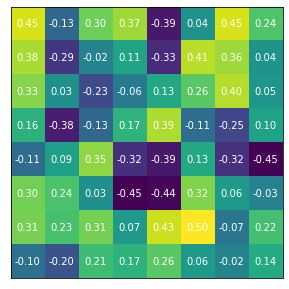

In [37]:

conv_layer = model.layers[1]
filters, biases = conv_layer.get_weights()

# # Normalize filter values to range [0, 1] for visualization
# f_min, f_max = filters.min(), filters.max()
# filters = (filters - f_min) / (f_max - f_min)

# Plot the filters
print(filters.shape)
n_filters = filters.shape[3]
n_columns = 1
n_rows = n_filters // n_columns
plt.figure(figsize=(n_columns * 5, n_rows * 5))

for i in range(n_filters):
    f = filters[:, :, :, i]
    ax = plt.subplot(n_rows, n_columns, i + 1)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.imshow(f[:, :, 0], cmap='viridis')

    # Display values
    for y in range(f.shape[0]):
        for x in range(f.shape[1]):
            plt.text(x, y, f'{f[y, x, 0]:.2f}', ha='center', va='center', color='white')

plt.show()

## Visualising combined matrices

In [56]:
def visualize_combined_matrix(matrix, title='Combined Transformation Matrix'):
    plt.figure(figsize=(10, 8))
    sns.heatmap(matrix.numpy(), annot=False, fmt=".2f", cmap='viridis')
    plt.title(title)
    plt.xlabel('Output Dimension')
    plt.ylabel('Input Dimension')
    plt.show()

In [57]:
combined_matrix.shape

TensorShape([64, 64])

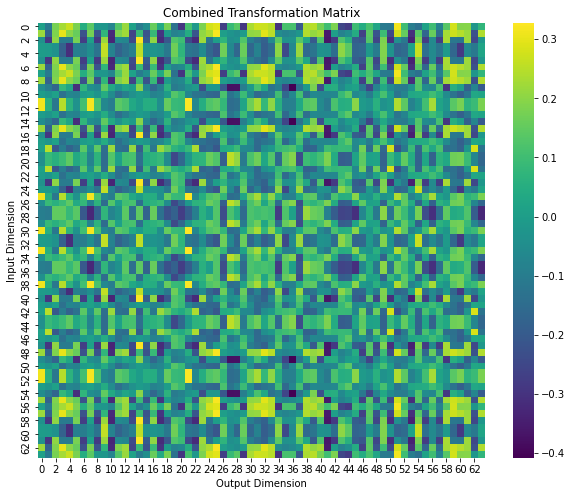

In [58]:
visualize_combined_matrix(combined_matrix)

In [60]:
import numpy as np
import tensorflow as tf

def generate_toeplitz_matrix_with_same_padding(filter, image_shape):
    filter_size = filter.shape[0]
    image_size = image_shape[0]
    output_size = image_size
    padded_image_size = image_size + filter_size - 1
    matrix_size = output_size * output_size
    toeplitz_matrix = np.zeros((matrix_size, padded_image_size * padded_image_size))

    for i in range(output_size):
        for j in range(output_size):
            row_start = i * output_size + j
            for fi in range(filter_size):
                for fj in range(filter_size):
                    padded_image_row = i + fi
                    padded_image_col = j + fj
                    col = padded_image_row * padded_image_size + padded_image_col
                    row = row_start
                    if 0 <= padded_image_row < padded_image_size and 0 <= padded_image_col < padded_image_size:
                        toeplitz_matrix[row, col] = filter[fi, fj]

    return toeplitz_matrix

# Example 8x8 image
image = np.random.rand(8, 8).astype(np.float32)
image_padded = np.pad(image, ((1, 1), (1, 1)), 'constant').flatten()  # Pad image and then flatten

# Example 3x3 filter
filter = np.random.rand(3, 3).astype(np.float32)

# Perform convolution using TensorFlow with 'SAME' padding
image_expanded = np.expand_dims(np.expand_dims(image, axis=0), axis=-1)  # Shape: (1, 8, 8, 1)
filter_expanded = np.expand_dims(np.expand_dims(filter, axis=-1), axis=-1)  # Shape: (3, 3, 1, 1)
conv_result = tf.nn.conv2d(image_expanded, filter_expanded, strides=[1, 1, 1, 1], padding='SAME')
conv_result_vectorized = tf.reshape(conv_result, [-1]).numpy()

# Generate Toeplitz matrix for the filter with 'SAME' padding
toeplitz_matrix = generate_toeplitz_matrix_with_same_padding(filter, image.shape)

# Perform matrix multiplication
matrix_multiplication_result = toeplitz_matrix @ image_padded

print(toeplitz_matrix)
print(toeplitz_matrix.shape)
# Print results for comparison
print("Convolution result vectorized:")
print(conv_result_vectorized)
print("\nMatrix multiplication result:")
print(matrix_multiplication_result)

# Check if they are the same
print("\nAre they equal?")
print(np.allclose(conv_result_vectorized, matrix_multiplication_result))


[[0.51631981 0.8763423  0.65928084 ... 0.         0.         0.        ]
 [0.         0.51631981 0.8763423  ... 0.         0.         0.        ]
 [0.         0.         0.51631981 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.26439732 0.         0.        ]
 [0.         0.         0.         ... 0.58946812 0.26439732 0.        ]
 [0.         0.         0.         ... 0.81309837 0.58946812 0.26439732]]
(64, 100)
Convolution result vectorized:
[0.5102872  0.80279255 1.1106774  1.6258247  2.242323   2.1150608
 2.0252073  0.9758651  1.4405961  2.0802617  1.9970102  2.8373075
 3.5274253  3.0911055  2.7050123  1.746592   1.5395291  1.9358389
 2.1380987  3.1466517  2.9296732  3.257732   2.5272985  2.3558617
 1.9589416  2.8518791  2.4311848  3.1052525  2.481873   2.5099216
 2.4612572  1.8479083  1.864996   2.609022   3.2819173  3.1321433
 3.0540285  2.547852   2.2544513  1.8241787  2.4974036  3.3528633
 3.7248452  3.3972268  1.92961    1.5616038  1.825895

In [40]:
toeplitz_matrix.shape, image_padded.shape, conv_result_vectorized.shape, matrix_multiplication_result.shape

((64, 100), (100,), (64,), (64,))

In [41]:
def generate_toeplitz_matrix(filter, image_shape):
    filter_size = filter.shape[0]
    image_size = image_shape[0]
    output_size = image_size - filter_size + 1
    matrix_size = output_size * output_size
    toeplitz_matrix = np.zeros((matrix_size, image_size * image_size))

    for i in range(output_size):
        for j in range(output_size):
            row_start = i * output_size + j
            for fi in range(filter_size):
                for fj in range(filter_size):
                    image_row = i + fi
                    image_col = j + fj
                    col = image_row * image_size + image_col
                    row = row_start
                    toeplitz_matrix[row, col] = filter[fi, fj]

    return toeplitz_matrix

In [44]:
combined_matrix

<tf.Tensor: shape=(64, 1), dtype=float32, numpy=
array([[-0.14256254],
       [ 0.0289476 ],
       [ 0.136321  ],
       [-0.04261608],
       [-0.04261609],
       [ 0.136321  ],
       [ 0.0289476 ],
       [-0.14256254],
       [ 0.0289476 ],
       [ 0.32681054],
       [ 0.24086691],
       [-0.26106796],
       [-0.26106796],
       [ 0.2408669 ],
       [ 0.32681054],
       [ 0.0289476 ],
       [ 0.13632101],
       [ 0.24086691],
       [ 0.04121851],
       [-0.25719056],
       [-0.25719056],
       [ 0.0412185 ],
       [ 0.2408669 ],
       [ 0.13632098],
       [-0.04261608],
       [-0.26106796],
       [-0.2571906 ],
       [-0.23499152],
       [-0.23499155],
       [-0.25719056],
       [-0.261068  ],
       [-0.04261607],
       [-0.04261608],
       [-0.261068  ],
       [-0.25719056],
       [-0.23499152],
       [-0.23499152],
       [-0.25719056],
       [-0.261068  ],
       [-0.04261607],
       [ 0.136321  ],
       [ 0.2408669 ],
       [ 0.0412185 ],
     

## Padded CNN

In [ ]:
class InvariantConvolutionLayer(tf.keras.layers.Layer):
    def __init__(self, filters, kernel_size, n, **kwargs):
        super(InvariantConvolutionLayer, self).__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size
        self.n = n
        self.d4_matrices = convert_d4_matrices_to_tf(generate_d4_matrices(n))

    def build(self, input_shape):
        self.kernel = self.add_weight(shape=(self.kernel_size, self.kernel_size, input_shape[-1], self.filters),
                                      initializer='glorot_uniform',
                                      trainable=True)

    def call(self, inputs):
        conv_output = tf.nn.conv2d(inputs, self.kernel, strides=[1, 1, 1, 1], padding='SAME')

        transformed_images = [
            tf.reshape(tf.linalg.matvec(matrix, tf.reshape(conv_output, [tf.shape(conv_output)[0], -1])),
                       [tf.shape(conv_output)[0], self.n, self.n, self.filters])
            for matrix in self.d4_matrices
        ]

        stacked_images = tf.stack(transformed_images, axis=0)
        mean_image = tf.reduce_mean(stacked_images, axis=0)

        return mean_image

    def get_combined_transformation_matrix(self):
        kernel_flat = tf.reshape(self.kernel, [self.kernel_size * self.kernel_size, self.filters])
        transformed_kernels = [
            tf.matmul(matrix, kernel_flat) 
            for matrix in self.d4_matrices
        ]
        combined_matrix = tf.reduce_mean(tf.stack(transformed_kernels), axis=0)
        return combined_matrix

In [63]:
# Define the model using Sequential
def create_model(input_shape, n, num_classes):
    model = tf.keras.models.Sequential([
        InvariantConvolutionLayer(filters=1, kernel_size=8, n=n, input_shape=input_shape),
        tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    return model

input_shape = (8, 8, 1)  # 8x8 image with 1 channel
num_classes = 5  # Number of classes (digits 0-9)
n = 8  # Dimension of the input image

X_train_expanded, X_test_expanded = np.expand_dims(X_train, axis=-1), np.expand_dims(X_test, axis=-1)

model = create_model(input_shape, n, num_classes)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc:.4f}')


Epoch 1/10


ValueError: in user code:

    File "/Users/iyerkartikshridhar/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "/Users/iyerkartikshridhar/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/iyerkartikshridhar/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "/Users/iyerkartikshridhar/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 994, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/Users/iyerkartikshridhar/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 1052, in compute_loss
        return self.compiled_loss(
    File "/Users/iyerkartikshridhar/opt/anaconda3/lib/python3.8/site-packages/keras/engine/compile_utils.py", line 265, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/Users/iyerkartikshridhar/opt/anaconda3/lib/python3.8/site-packages/keras/losses.py", line 152, in __call__
        losses = call_fn(y_true, y_pred)
    File "/Users/iyerkartikshridhar/opt/anaconda3/lib/python3.8/site-packages/keras/losses.py", line 272, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/Users/iyerkartikshridhar/opt/anaconda3/lib/python3.8/site-packages/keras/losses.py", line 1990, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "/Users/iyerkartikshridhar/opt/anaconda3/lib/python3.8/site-packages/keras/backend.py", line 5529, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (None, 5) and (None, 4, 4, 5) are incompatible
